In [5]:
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [6]:
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 6879970079879876591,
 name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 6966018048
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 11775051909273740344
 physical_device_desc: "device: 0, name: NVIDIA GeForce GTX 1070, pci bus id: 0000:01:00.0, compute capability: 6.1"]

In [7]:
# import sys
# log_path = 'log.txt'
# sys.stdout = open(log_path, "w")

import h5py
h5 = h5py.File('./data/All_cases_100x100_per500_zoom.hdf5', mode='r')
dataset = h5.get('phi')

data_sz = dataset.shape[0]
indexes = np.arange(data_sz)
np.random.shuffle(indexes)
# 4-fold cross validation - 2
train_index = np.sort(indexes[np.concatenate((np.arange(0,int(0.25 * data_sz)), np.arange(int(0.5 * data_sz),len(indexes))), axis=0)])
val_index = np.sort(indexes[int(0.25 * data_sz) : int(0.5 * data_sz)])
print(train_index)
print(len(train_index))
print(val_index)
print(len(val_index))

[ 0  1  2  3  5  6  8 10 11 12 13 14 15 16 17 18 20 22 23 24 25 28 30 31
 32 33 34 36 37 39 40 41 42 43 45 46 47 48 49 50 51 52 53 54 56 57 58 59
 64 65 68 69 70 71 72 73 75 77 78 79 80 82 83 85 86 87 88]
67
[ 4  7  9 19 21 26 27 29 35 38 44 55 60 61 62 63 66 67 74 76 81 84]
22


In [8]:
# this part is a bit slow
train_dataset = dataset[train_index,...]
val_dataset = dataset[val_index,...]

dataset.shape

(89, 70, 100, 100, 3)

In [9]:
def create_shifted_frames_3to1(data):
    x1 = np.expand_dims(data[:, 1 : data.shape[1] - 3, :, :, 0]+data[:, 1 : data.shape[1] - 3, :, :, 1],4)
    x2 = np.expand_dims(data[:, 2 : data.shape[1] - 2, :, :, 0]+data[:, 2 : data.shape[1] - 2, :, :, 1],4)
    x3 = np.expand_dims(data[:, 3 : data.shape[1] - 1, :, :, 0]+data[:, 3 : data.shape[1] - 1, :, :, 1],4)
    x = np.concatenate((x1,x2,x3), axis=4)
    y = data[:, 4 : data.shape[1], :, :, 0]
    y = np.expand_dims(y,4)
    return x,y

x_train, y_train = create_shifted_frames_3to1(train_dataset)
x_val, y_val = create_shifted_frames_3to1(val_dataset)

print("Training Dataset Shapes: " + str(x_train.shape) + ", " + str(y_train.shape))
print("Validation Dataset Shapes: " + str(x_val.shape) + ", " + str(y_val.shape))

Training Dataset Shapes: (67, 66, 100, 100, 3), (67, 66, 100, 100, 1)
Validation Dataset Shapes: (22, 66, 100, 100, 3), (22, 66, 100, 100, 1)


Displaying frames for example 0.


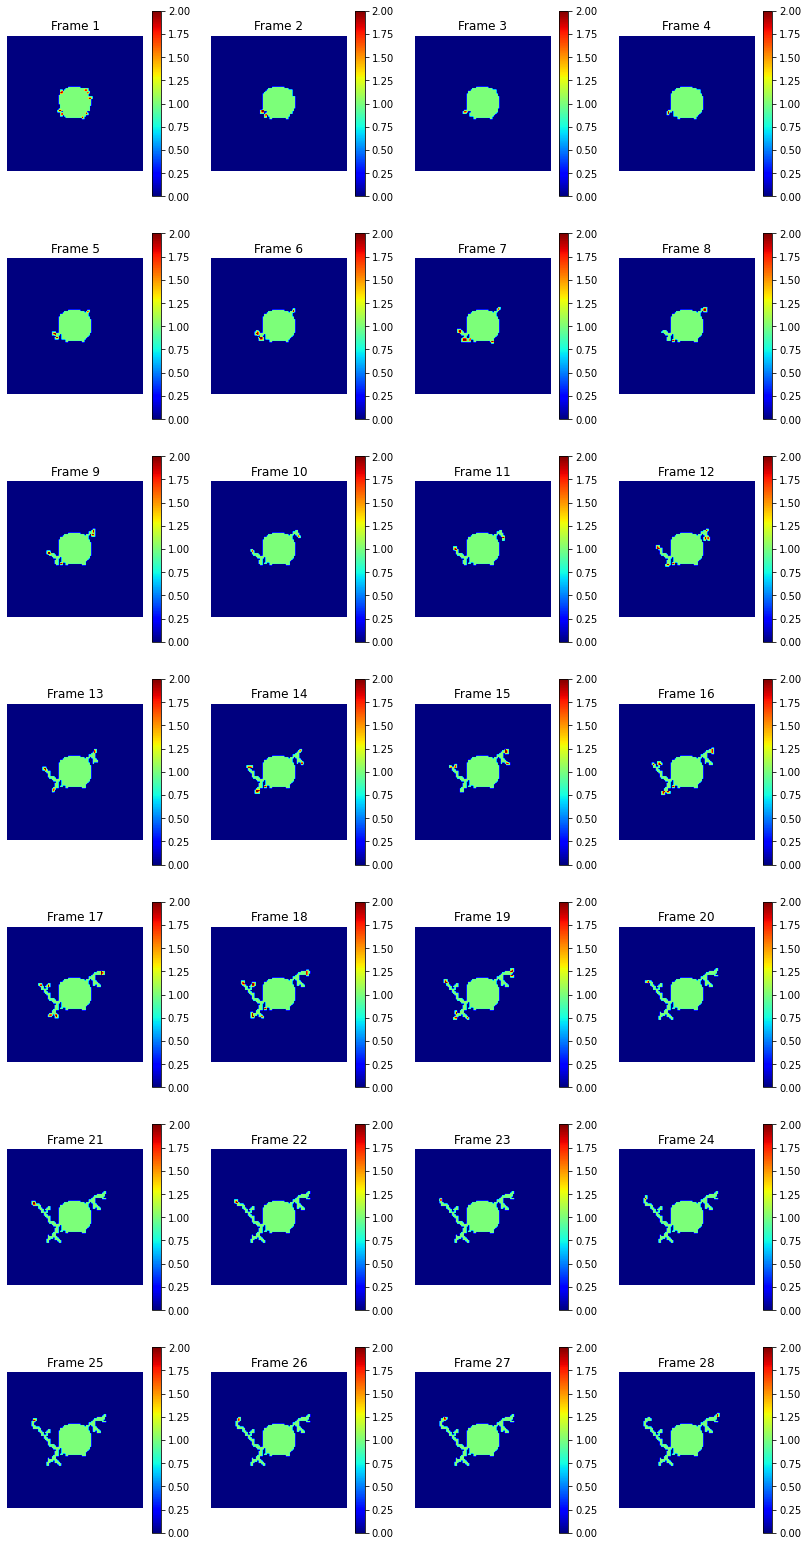

In [10]:
fig, axes = plt.subplots(7, 4, figsize=(14, 28))

data_choice = np.random.choice(range(len(x_train)), size=1)[0]
fig_ind = 1
for idx, ax in enumerate(axes.flat):
    plt.subplot(7,4,fig_ind)
    fig_ind += 1
    plt.imshow(np.squeeze(x_train[data_choice][idx][:,:,0]),cmap='jet')
    plt.title(f"Frame {idx + 1}")
    plt.axis("off")
    plt.colorbar()
    
print(f"Displaying frames for example {data_choice}.")
plt.show()

Displaying frames for example 0.


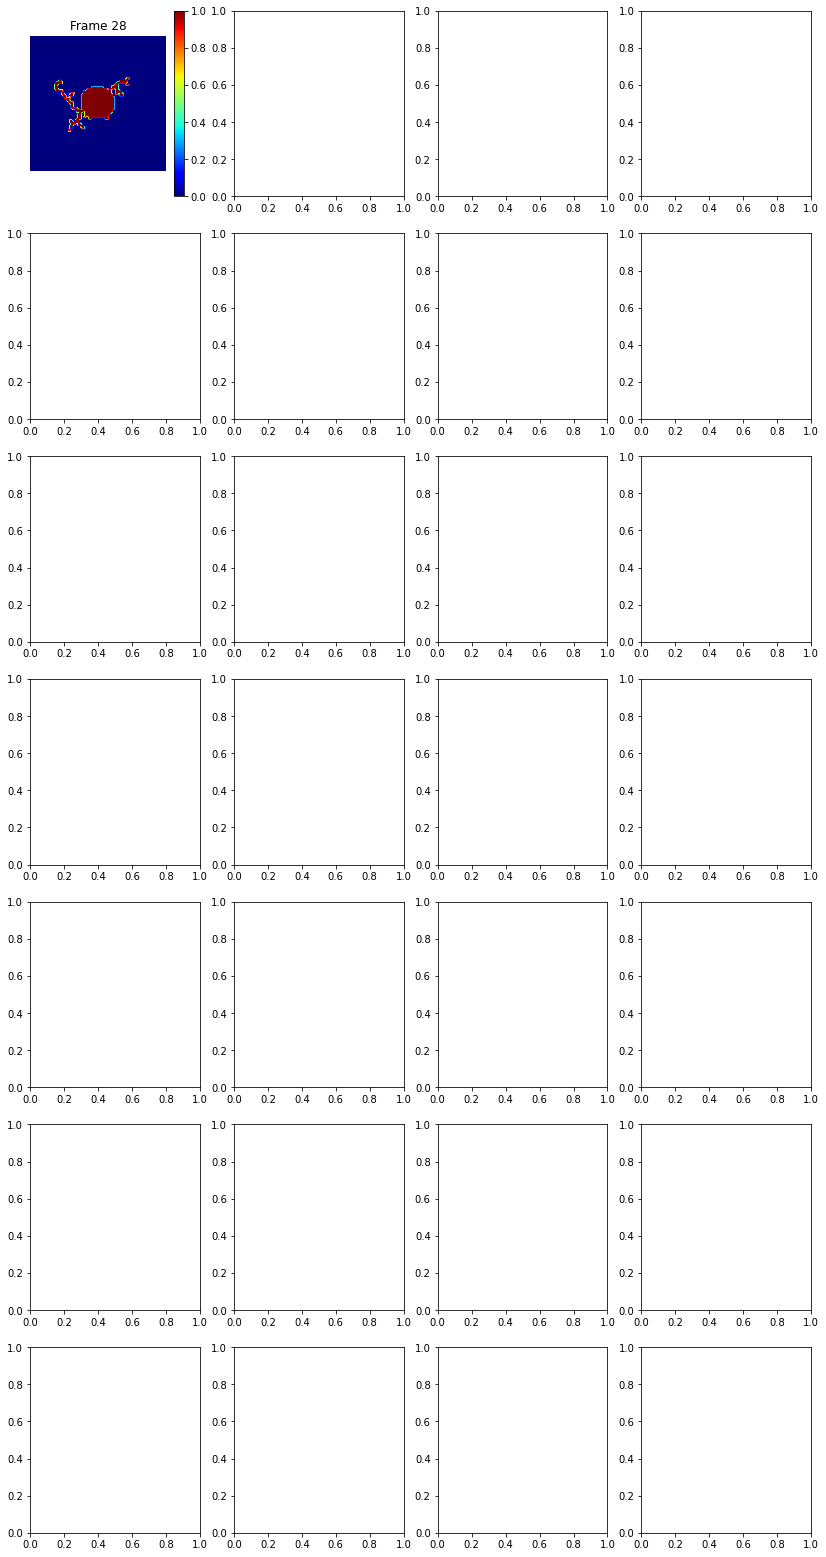

In [11]:
fig, axes = plt.subplots(7, 4, figsize=(14, 28))

fig_ind = 1
for idx, ax in enumerate(axes.flat):
    plt.subplot(7,4,fig_ind)

    plt.imshow(np.squeeze(y_train[data_choice][idx][:,:,0]), cmap="jet")
    plt.title(f"Frame {idx + 1}")
    plt.axis("off")
    plt.colorbar()
    
# Print information and display the figure.
print(f"Displaying frames for example {data_choice}.")
plt.show()

In [12]:
inp = layers.Input(shape=(None, *x_train.shape[2:]))

drop_rate = 0.1
x0 = layers.TimeDistributed(layers.Conv2D(
    filters=64,
    kernel_size=(5, 5),
    strides = (2, 2),
    padding="valid",
    activation="relu",
))(inp)
x0 = layers.Dropout(drop_rate)(x0)
x1 = layers.TimeDistributed(layers.Conv2D(
    filters=128,
    kernel_size=(5, 5),
    strides = (2, 2),
    padding="valid",
    activation="relu",
))(x0)
x1 = layers.Dropout(drop_rate)(x1)
x2 = layers.ConvLSTM2D(
    filters=128,
    kernel_size=(5, 5),
    padding="same",
    return_sequences=True,
    activation="relu",
    recurrent_dropout=drop_rate,
)(x1)
x3 = layers.Concatenate(axis=4)([x1,x2])
x4 = layers.TimeDistributed(layers.Conv2DTranspose(
    filters=64,
    kernel_size=(6, 6),
    strides = (2, 2),
    padding="valid",
    activation="relu",
))(x3)
x4 = layers.Dropout(drop_rate)(x4)
x5 = layers.Concatenate(axis=4)([x0,x4])
x6 = layers.TimeDistributed(layers.Conv2DTranspose(
    filters=1,
    kernel_size=(6, 6),
    strides = (2, 2),
    padding="valid",
    activation="sigmoid",
))(x5)
x6 = layers.Dropout(drop_rate)(x6)

In [13]:
model = keras.models.Model(inp, x6)
model.compile(
    loss=keras.losses.MeanSquaredError(reduction="auto", name="mean_squared_error"),
    optimizer=keras.optimizers.Adam(learning_rate=1e-5))
print(model.summary())

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, None, 100, 1 0                                            
__________________________________________________________________________________________________
time_distributed (TimeDistribut (None, None, 48, 48, 4864        input_1[0][0]                    
__________________________________________________________________________________________________
dropout (Dropout)               (None, None, 48, 48, 0           time_distributed[0][0]           
__________________________________________________________________________________________________
time_distributed_1 (TimeDistrib (None, None, 22, 22, 204928      dropout[0][0]                    
______________________________________________________________________________________________

In [14]:
test = False

if test == True:
    model = keras.models.load_model('./saved_model/model_conv_lstm_4fold3')
else:
    early_stopping = keras.callbacks.EarlyStopping(monitor="val_loss", patience=20)
    reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor="val_loss", patience=10)

    epochs = 500
    batch_size = 2

    with tf.device('/device:GPU:0'):
        model.fit(
            x_train,
            y_train,
            batch_size=batch_size,
            epochs=epochs,
            validation_data=(x_val, y_val),
            callbacks=[early_stopping, reduce_lr],
        )
    model.save('./saved_model/model_conv_lstm_4fold3') 

Epoch 1/500
34/34 [==============================] - 74s 2s/step - loss: 0.2773 - val_loss: 0.2489
Epoch 2/500
34/34 [==============================] - 57s 2s/step - loss: 0.2746 - val_loss: 0.2463
Epoch 3/500
34/34 [==============================] - 58s 2s/step - loss: 0.2718 - val_loss: 0.2431
Epoch 4/500
34/34 [==============================] - 58s 2s/step - loss: 0.2610 - val_loss: 0.2314
Epoch 5/500
34/34 [==============================] - 57s 2s/step - loss: 0.2539 - val_loss: 0.2289
Epoch 6/500
34/34 [==============================] - 57s 2s/step - loss: 0.2484 - val_loss: 0.2230
Epoch 7/500
34/34 [==============================] - 57s 2s/step - loss: 0.2413 - val_loss: 0.2168
Epoch 8/500
34/34 [==============================] - 57s 2s/step - loss: 0.2342 - val_loss: 0.2104
Epoch 9/500
34/34 [==============================] - 57s 2s/step - loss: 0.2271 - val_loss: 0.2039
Epoch 10/500
34/34 [==============================] - 57s 2s/step - loss: 0.2201 - val_loss: 0.1974
Epoch 11/

In [15]:
import matlab.engine
eng = matlab.engine.start_matlab()

rand_case = np.random.randint((len(val_dataset)))

example_x = x_val[rand_case,...]
example_y = y_val[rand_case,...]
# example_theta = theta_val[rand_case,...]

plt.figure(figsize=(16, 4), dpi=60)
plt.subplot(1,3,1)
plt.imshow(example_x[0,:,:,0], cmap='jet')
plt.title('Ground truth at frame 0')

plt.subplot(1,3,2)
plt.imshow(example_x[0,:,:,1], cmap='jet')
plt.title('Ground truth at frame 0')

plt.subplot(1,3,3)
plt.imshow(example_x[0,:,:,2], cmap='jet')
plt.title('Ground truth at frame 0')
plt.show()

x_in = np.expand_dims(np.expand_dims(example_x[0,...],axis=0),axis=0)

for i in range(example_x.shape[0]-3):

    new_prediction = model.predict(x_in)
    temp = np.zeros([1,1,100,100,3])

    # tips = np.round(eng.generate_tips_for_python(matlab.double(np.array(new_prediction[0,0,:,:,0]).astype('float64')),5000))
    tips = np.round(example_x[i,:,:,1])

    temp[0,0,:,:,0] = x_in[0,0,:,:,1]
    temp[0,0,:,:,1] = x_in[0,0,:,:,2]
    temp[0,0,:,:,2] = np.round(new_prediction[0,0,:,:,0])+tips

    x_in = temp

    mre = np.sqrt(np.sum(np.square(new_prediction[0,0,:,:,0]-example_y[i,:,:,0])/(new_prediction.shape[2]*new_prediction.shape[3])))

    plt.figure(figsize=(16, 4), dpi=60)

    plt.subplot(1,4,1)
    plt.imshow(new_prediction[0,0,:,:,0], cmap='jet')
    plt.colorbar()
    plt.title('Prediction at frame %d'%(i+3))

    plt.subplot(1,4,2)
    plt.imshow(tips, cmap='jet')
    plt.colorbar()
    plt.title('Detected tips at frame %d'%(i+3))

    plt.subplot(1,4,3)
    plt.imshow(example_y[i,:,:,0], cmap='jet')
    plt.colorbar()
    plt.title('Ground truth at frame %d'%(i+3))

    plt.subplot(1,4,4)
    plt.imshow(new_prediction[0,0,:,:,0]-example_y[i,:,:,0], cmap='jet')
    plt.colorbar()
    plt.title('Absolute error at frame %d'%(i+3))
    plt.xlabel('Mean relative error: %f'%mre)

    plt.show()
    
eng.quit()


ModuleNotFoundError: No module named 'matlab'

In [ ]:
import matlab.engine
from tqdm import tqdm
eng = matlab.engine.start_matlab()

rand_case = np.random.randint((len(val_dataset)))

mre = []
for rand_case in tqdm (range(len(val_dataset)), desc="Running ..."):
    example_x = x_val[rand_case,...]
    example_y = y_val[rand_case,...]
    x_in = np.expand_dims(np.expand_dims(example_x[0,...],axis=0),axis=0)

    for i in range(example_x.shape[0]-3):

        new_prediction = model.predict(x_in)
        temp = np.zeros([1,1,100,100,3])

        # tips = np.round(eng.generate_tips_for_python(matlab.double(np.array(new_prediction[0,0,:,:,0]).astype('float64')),5000))
        tips = np.round(example_x[i,:,:,1])
        temp[0,0,:,:,0] = x_in[0,0,:,:,1]
        temp[0,0,:,:,1] = x_in[0,0,:,:,2]
        temp[0,0,:,:,2] = np.round(new_prediction[0,0,:,:,0])+tips

        x_in = temp

        mre.append(np.sqrt(np.sum(np.square(new_prediction[0,0,:,:,0]-example_y[i,:,:,0])/(new_prediction.shape[2]*new_prediction.shape[3]))))

print(sum(mre) / len(mre))
eng.quit()


Running ...: 100%|██████████| 23/23 [00:35<00:00,  1.56s/it]

0.11941701591589754
